### Mehregan Nazarmohsenifakori
### 0001120680
### mehrega.nazarmohseni@studio.unibo.it

#Separation of CIFAR-10 Images

The model takes as input an image created by averaging two random samples from CIFAR-10 and is tasked with predicting the categories of the two components.

The first image belongs to the first five categories (airplane, automobile, bird, cat, deer), while the second belongs to the remaining categories (dog, frog, horse, ship, truck). The model must return two labels, each within a range of five possible values.

The evaluation metric for the model is as follows: calculate the classification accuracy for the two component images and then compute their average.

The metric should be evaluated on 10,000 inputs generated from test data. Repeat the calculation 10 times and measure the standard deviation, which must be reported.

A data generator and some examples are provided below.

Importing the necessary libraries. I will be relying on __TensorFlow__ and __Keras__ to handle the image data, craft my model, and optimize it for best performance:

In [ ]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

#Data preparation

In this section, I download the __CIFAR-10__ dataset from Keras library and the data of __cifar10_x_train__ and __cifar10_x_test__ divide by 255 (normalizes) and type of them convert pixel values ​​to float32.

In [ ]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

# CIFAR-10 classes
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Change the data type and normalize the data
cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step



In this section, I split the training data into an __90:10__ ratio for __training__ and __validation__, ensuring that the number of samples from each class is balanced in both the training and validation sets.

In [ ]:
# Split the training data into an 90:10 ratio for training and validation
X_train, X_val, y_train, y_val = train_test_split(cifar10_x_train, cifar10_y_train, test_size=0.1, random_state=42, stratify=cifar10_y_train)

In this section, I split the CIFAR-10 dataset into two subsets based on class labels for training, validation, and testing.  
- Classes with labels less than 5 are grouped into the first subset (Subset 1).  
- Classes with labels 5 and above are grouped into the second subset (Subset 2).  



In [ ]:
# Split training dataset into two subsets
cond_1 = y_train[:,0] < 5
cifar10_x_train_1 = X_train[cond_1]
cifar10_y_train_1 = y_train[cond_1]

cond_2 = y_train[:,0] >= 5
cifar10_x_train_2 = X_train[cond_2]
cifar10_y_train_2 = y_train[cond_2]

# Split validation dataset into two subsets
cond_1_val = y_val[:,0] < 5
cifar10_x_val_1 = X_val[cond_1_val]
cifar10_y_val_1 = y_val[cond_1_val]

cond_2_val = y_val[:,0] >= 5
cifar10_x_val_2 = X_val[cond_2_val]
cifar10_y_val_2 = y_val[cond_2_val]

# Split testing dataset into two subsets
cond_1_test = cifar10_y_test[:,0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]

#Datagenerator

Now define the generator `datagenerator` function. The input consists of two datasets (X1,X2), their corresponding labels (Y1,Y2), and a batch size.

The generator returns (x_data,y_data), where:
* x_data is a batch of images obtained by averaging random samples from X1 and X2.
* y_data is a pair of batches of labels corresponding to the component images, expressed in categorical format.


In [ ]:
def datagenerator(X1,X2,Y1,Y2,batchsize):
  size1 = X1.shape[0]
  size2 = X2.shape[0]
  Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
  Y2_cat = tf.keras.utils.to_categorical(Y2-5, num_classes=5)

  while True:
    num1 = np.random.randint(0, size1, batchsize)
    num2 = np.random.randint(0, size2, batchsize)
    x_data = (X1[num1] + X2[num2]) / 2.0
    y_data = (Y1_cat[num1],Y2_cat[num2])

    yield x_data, y_data

In this section, I create data generators for training, validation, and testing:

- **Training Generator (`train_gen`)**: Uses a batch size of 128 and generates training data by combining `cifar10_x_train_1` and `cifar10_x_train_2` with their corresponding labels.

- **Validation Generator (`val_gen`)**: Generates the entire validation dataset in one batch by setting the batch size equal to the total number of validation samples from both subsets.

- **Test Generator (`testgen`)**: Generates the entire test dataset in one batch.


In [ ]:
train_batchsize = 128
train_gen = datagenerator(cifar10_x_train_1, cifar10_x_train_2, cifar10_y_train_1, cifar10_y_train_2, batchsize=train_batchsize)
val_batchsize = cifar10_x_val_1.shape[0] + cifar10_x_val_2.shape[0]
val_gen = datagenerator(cifar10_x_val_1, cifar10_x_val_2, cifar10_y_val_1, cifar10_y_val_2, batchsize=val_batchsize)
testgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,10000)

#CNN Model

<div style="border-radius:12px; padding: 20px; background-color: #e2c9ff; font-size:120%; text-align:left">

My model contains multiple convolutional layers followed by max-pooling and dropout layers, and finally a fully connected layer for classification.

Here is a brief explanation of the architecture:

- The network begins with __a pair of Conv2D layers__, each with __64 filters of size 3x3__. This is followed by a __Batch Normalization__ layer which accelerates training and provides some level of __regularization__, helping to prevent overfitting.

    
- The pairs of Conv2D layers are followed by a __MaxPooling2D layer__, which reduces the spatial dimensions (height and width), effectively providing a form of translation invariance and reducing computational complexity. This is followed by a __Dropout layer__ that randomly sets a fraction (0.25 for the first dropout layer) of the input units to 0 at each update during training, helping to prevent overfitting.

    
- This pattern of two Conv2D layers, followed by a Batch Normalization layer, a MaxPooling2D layer, and a Dropout layer, repeats three more times. The number of filters in the Conv2D layers are 64, 128, and then 256. This increasing pattern helps the network to learn more complex features at each level. The dropout rate also increases at each step.

    
- After the convolutional and pooling layers, a __Flatten layer__ is used to convert the 2D outputs of the preceding layer into a 1D vector and add a __Dense(fully connected) layer__ with __256 neurons__ and __ELU activation__, followed by a dropout layer with a 0.25 dropout rate to reduce overfitting.

    
- Finally, two __Dense (or fully connected) layer__ are used for classification two outputs. each one have 5 units, and a __softmax activation function__ is used to convert the outputs to probability scores for each class.

In [ ]:
def create_cnn_model():

    weight_decay = 0.0001

    inputs = layers.Input(shape=(32, 32, 3))

    # First convolutional layer with 64 filters of size 3x3
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='elu', kernel_regularizer=l2(weight_decay))(inputs)
    # Batch normalization layer
    x = layers.BatchNormalization()(x)

    # Second convolutional layer similar to the first
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='elu', kernel_regularizer=l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)

    # First max pooling layer with pool size of 2x2
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    # Dropout layer with 0.25 dropout rate
    x = layers.Dropout(rate=0.25)(x)

    # Third and fourth convolutional layers with 64 filters
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='elu', kernel_regularizer=l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='elu', kernel_regularizer=l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)

    # Second max pooling layer and increase dropout rate to 0.3
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(rate=0.3)(x)

    # Fifth and sixth convolutional layers with 128 filters
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='elu', kernel_regularizer=l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='elu', kernel_regularizer=l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)

    # Third max pooling layer and increase dropout rate to 0.4
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(rate=0.4)(x)

    # Seventh and eighth convolutional layers with 256 filters
    x = layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='elu', kernel_regularizer=l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='elu', kernel_regularizer=l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)

    # Fourth max pooling layer and increase dropout rate to 0.5
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(rate=0.5)(x)

    # Flatten the tensor output from the previous layer
    x = layers.Flatten()(x)

    # Dense layer and dropout with 0.25 rate
    x = layers.Dense(256, activation='elu')(x)
    x = layers.Dropout(rate=0.25)(x)

    # Two dense output layers with softmax activation
    output1 = layers.Dense(5, activation='softmax', name='output1')(x)
    output2 = layers.Dense(5, activation='softmax', name='output2')(x)

    model = Model(inputs=inputs, outputs={'output1': output1, 'output2': output2})

    return model


In [ ]:
model = create_cnn_model()

# Display the detailed architecture of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 16, 16, 64)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 64)     │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 64)     │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 64)       │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 8, 8, 64)       │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 128)      │         73,856 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 8, 8, 128)      │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 8, 8, 128)      │        147,584 │ batch_normalization_4… │
├──────────────────────

 Total params: 1,488,330 (5.68 MB)

 Trainable params: 1,486,282 (5.67 MB)

 Non-trainable params: 2,048 (8.00 KB)

In this section, I want to visualize architecture of my model:

In [ ]:
!pip install visualkeras -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 38.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


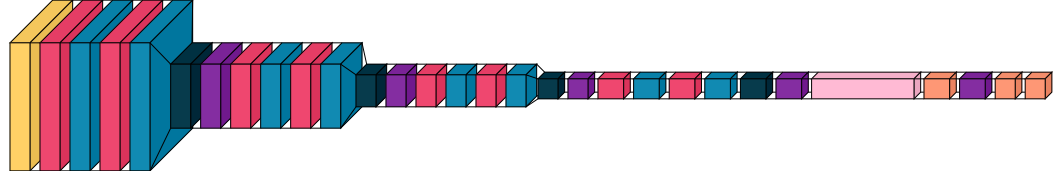

In [ ]:
import visualkeras

visualkeras.layered_view(model)

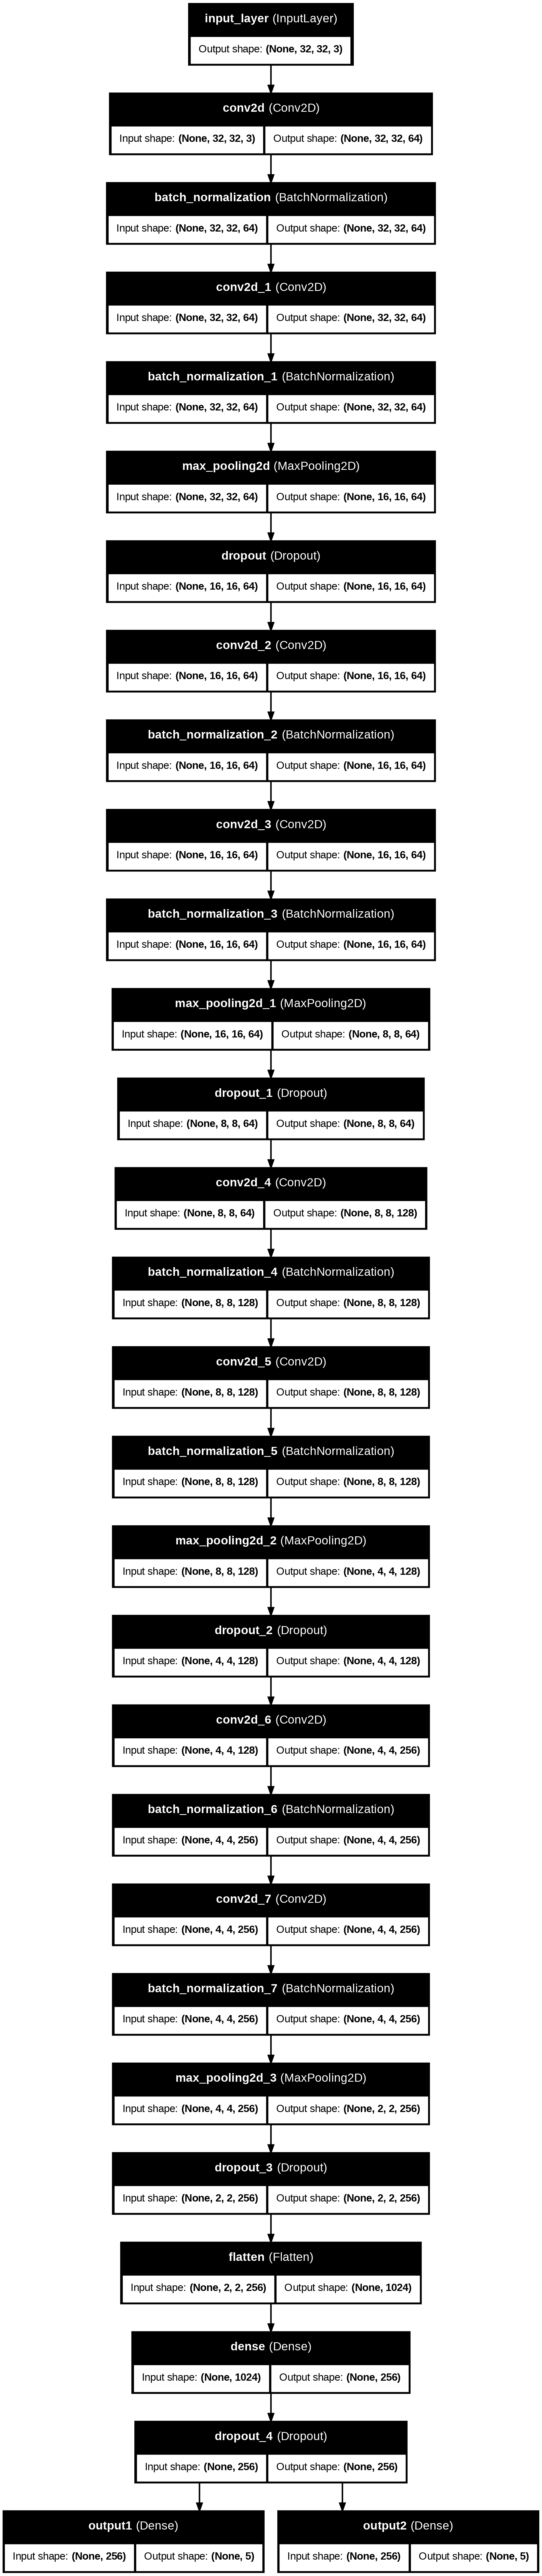

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

# Training the CNN Model

<div style="border-radius:12px; padding: 20px; background-color: #e2c9ff; font-size:120%; text-align:left">

In this section, I want to train my CNN model. During the training, the model's performance is evaluated on the validation data after each epoch. I've added a couple of callback functions to enhance the training process:

* The __ReduceLROnPlateau callback__ is used to decrease the learning rate (factor=0.7) if the validation loss fails to improve for 10 consecutive epochs. This dynamic adjustment helps the model move closer to the global minimum of the loss function during periods of stagnation, enhancing the training process convergence.
    

* The __EarlyStopping callback__ is employed to monitor the validation loss and halt the training process when there hasn't been any improvement for a certain number of epochs, ensuring that the model doesn't waste computational resources and time. Furthermore, this callback restores the best weights from the training process, ensuring we conclude with the optimal model configuration from the epochs.

In [ ]:
epochs = 400
steps_per_epoch = ((cifar10_x_train_1.shape[0] + cifar10_x_train_2.shape[0]) // train_batchsize)
validation_steps= ( (cifar10_x_val_1.shape[0] + cifar10_x_val_2.shape[0])// val_batchsize)
# Define the optimizer (Adam)
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
                  metrics={'output1': ['accuracy'], 'output2': ['accuracy']})

# ReduceLROnPlateau callback
# The learning rate will be reduced (factor=0.7) if no improvement in validation loss is seen over 10 epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=0.00001)

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data = val_gen, validation_steps=validation_steps, callbacks=[reduce_lr, early_stopping])

Epoch 1/400
351/351 ━━━━━━━━━━━━━━━━━━━━ 39s 64ms/step - loss: 3.8250 - output1_accuracy: 0.3163 - output1_loss: 1.8860 - output2_accuracy: 0.3368 - output2_loss: 1.8505 - val_loss: 4.9964 - val_output1_accuracy: 0.1992 - val_output1_loss: 2.6605 - val_output2_accuracy: 0.3758 - val_output2_loss: 2.2432 - learning_rate: 0.0010
Epoch 2/400
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 2.7213 - output1_accuracy: 0.4217 - output1_loss: 1.3892 - output2_accuracy: 0.5090 - output2_loss: 1.2382 - val_loss: 2.5420 - val_output1_accuracy: 0.4726 - val_output1_loss: 1.2667 - val_output2_accuracy: 0.5386 - val_output2_loss: 1.1773 - learning_rate: 0.0010
Epoch 3/400
351/351 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 2.3610 - output1_accuracy: 0.4952 - output1_loss: 1.2338 - output2_accuracy: 0.5989 - output2_loss: 1.0277 - val_loss: 2.1071 - val_output1_accuracy: 0.5500 - val_output1_loss: 1.1169 - val_output2_accuracy: 0.6512 - val_output2_loss: 0.8865 - learning_rate: 0.0010
Epoch 4/400
351

#Visualizing the Learning Curves

I am going to Generate plots for visualizing the training and validation loss, and accuracy evolution over epochs:

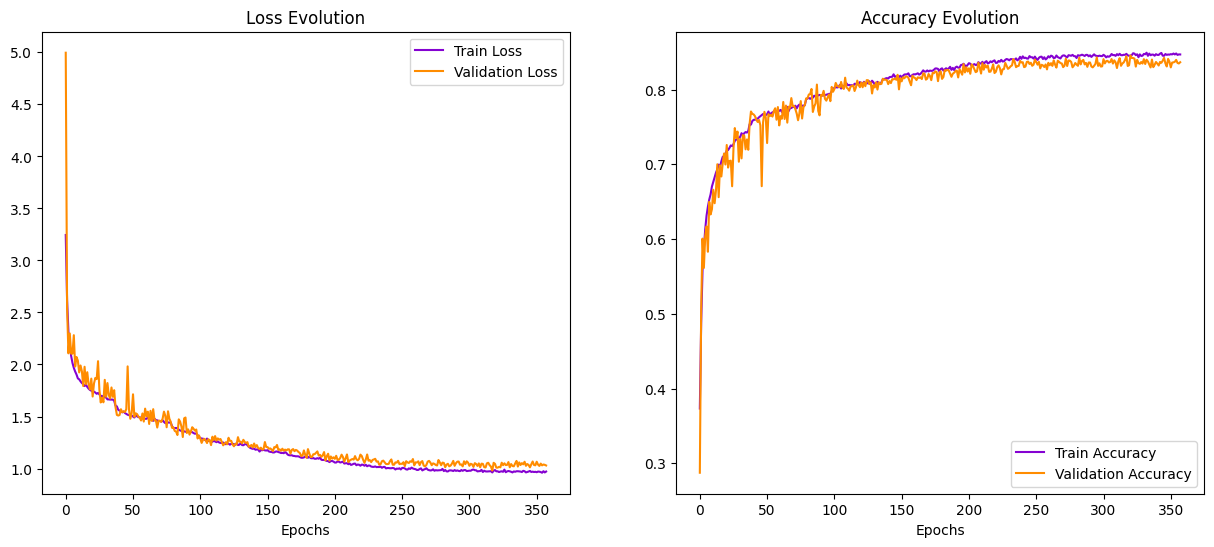

In [ ]:
plt.figure(figsize=(15,6))

train_acc = (np.array(history.history['output1_accuracy']) + np.array(history.history['output2_accuracy']) ) / 2
val_acc = (np.array(history.history['val_output1_accuracy']) + np.array(history.history['val_output2_accuracy'])) / 2

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(np.array(history.history['loss']), label='Train Loss', color='#8502d1')
plt.plot(np.array(history.history['val_loss']), label='Validation Loss', color='darkorange')
plt.xlabel('Epochs')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy', color='#8502d1')
plt.plot(val_acc, label='Validation Accuracy', color='darkorange')
plt.xlabel('Epochs')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

Based on the visualizations above, it's evident that the model is performing well without signs of overfitting. This conclusion is supported by the close alignment of training and validation accuracy and loss values throughout the training process. The gap between training and validation accuracy remains minimal, indicating that the model generalizes well to unseen data. Similarly, the model's loss on validation data closely follows the training loss, reinforcing the assertion of good generalization. Therefore, the model appears to be well regularized and not overfitting to the training data.

#Evaluating the Optimal Model on Test Data

As we have set `restore_best_weights=True` in EarlyStopping, after training, the model itself will have the best weights Following this, I will use this model to evaluate its performance on the test data, calculating the test accuracy and loss:

In [ ]:
def eval_model(model):

    # Get a batch of data (inputs and labels) from the generator
    eval_samples_x, eval_samples_y = next(testgen)

    # Evaluate the model on the generated data
    eval_result = model.evaluate(eval_samples_x, eval_samples_y, verbose=0)

    accuracy_output1 = eval_result[3]  # accuracy for the first output
    accuracy_output2 = eval_result[4]  # accuracy for the second output

    # Compute the average accuracy
    average_accuracy = (accuracy_output1 + accuracy_output2) / 2.0

    return average_accuracy

Evaluating on `testgen` for once:

In [ ]:
eval_model(model)

0.8391499817371368

I repeat the evaluation ten times, and compute the standard deviation:

In [ ]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(model))

In [ ]:
print("mean accuracy = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

mean accuracy =  0.8331299901008606
standard deviation =  0.0037220429132283107


The result shows when I evaluated the test data (`testgen`) ten times, the __average accuracy__ of my model is  __0.8331 (83.31%)__ and the __standard deviation__ is __0.0037__ .